幅広くデータを見ていく
* 加速度の波形を並べていみる
* ウィンドウフレームごとの平均，分散の変化

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Parametor about  " Sliding Window " 
WindowWidth =np.array([128,256,512,1024,2048,4096]) # Window Width
SlidingWidth =WindowWidth/4 #sliding window

# Parametor about Neural Network
AEDimention = 16

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/home/takeyama/Documents/"

if not os.path.exists(StorePath+'/'+TITLE+'dictionary/'): 
    os.makedirs(StorePath+'/'+TITLE+'dictionary/')
DictionaryDataPath=StorePath+'/'+TITLE+'dictionary/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'window/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'window/')
WindowDataPath=StorePath+'/'+TITLE+DATE+'window/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+'/'+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'parametor/')
ParametorPath=StorePath+'/'+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'result/')
ResultPath=StorePath+'/'+TITLE+DATE+'result/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'graph/')
GraphPath=StorePath+'/'+TITLE+DATE+'graph/'

センサデータの読み込み

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
import processing
import window

Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

DataFileNameList,SensorName=SensorDataFileNameList(DataPath)
l=[]
for i in range( len(DataFileNameList) ):
    l.append( ImportCSV(DataPath+DataFileNameList[i],Label[i]) )

In [6]:
def MakeCommonSection(inputDataArray):
    # 共通区間のスタート時間、ゴール時間を求める
    # スタート時間を求める
    startTime = min(inputDataArray[0]['Time'])
    
    for i in range(len(inputDataArray)):
        if startTime < min(inputDataArray[i]['Time']):
            startTime = min(inputDataArray[i]['Time'])
    
    # ゴール時間を求める
    goalTime = max(inputDataArray[0]['Time'])
    
    for i in range(len(inputDataArray)):
        if goalTime > max(inputDataArray[i]['Time']):
            goalTime = max(inputDataArray[i]['Time'])

    # 共通区間のスタート時間のインデックス、ゴール時間のインデックスを探索する
    def CalcSearchIndexFromTime(data, keyTime):
        """
        data　辞書型
        keyTime data['Time']の中の探す値
        """
        count = 0
        for i in range(0, len(data['Time'])):
            if keyTime == data['Time'][i]:
                print str(keyTime)+' is much in the index  whose number is '+str(i)
                return i
            
    startIndex = np.array([])
    goalIndex = np.array([])
    for obj in inputDataArray:
        print 'start'
        startIndex = np.append(startIndex, CalcSearchIndexFromTime(obj, startTime) ).astype(int)
        print 'goal'
        goalIndex = np.append(goalIndex, CalcSearchIndexFromTime(obj, goalTime) ).astype(int)

    tmp={}
    comDataArray =[]
    key={}

    # センサデータすべて（時刻、加速度、角速度）に対して共通区間のみのデータを抽出
    for number,iDA in enumerate( inputDataArray ):

        tmp['AccX'] = copy.deepcopy( iDA['AccX'][startIndex[number]:goalIndex[number]] )
        tmp['AccY'] = copy.deepcopy( iDA['AccY'][startIndex[number]:goalIndex[number]] )
        tmp['AccZ'] = copy.deepcopy( iDA['AccZ'][startIndex[number]:goalIndex[number]] )
        tmp['GyrX'] = copy.deepcopy( iDA['GyrX'][startIndex[number]:goalIndex[number]] )
        tmp['GyrY'] = copy.deepcopy( iDA['GyrY'][startIndex[number]:goalIndex[number]] )
        tmp['GyrZ'] = copy.deepcopy( iDA['GyrZ'][startIndex[number]:goalIndex[number]] )
        tmp['Time'] = copy.deepcopy( iDA['Time'][startIndex[number]:goalIndex[number]] )
        tmp['Name'] = copy.deepcopy( iDA['Name'] )
        comDataArray.append(copy.deepcopy(tmp) )    
        key[ tmp['Name'] ] = number
       
    return key,comDataArray

In [7]:
TrimKey,TrimData = MakeCommonSection(l)

start
36290413 is much in the index  whose number is 35
goal
37368283 is much in the index  whose number is 1077905
start
36290413 is much in the index  whose number is 0
goal
37368283 is much in the index  whose number is 1077870
start
36290413 is much in the index  whose number is 959
goal
37368283 is much in the index  whose number is 1078829
start
36290413 is much in the index  whose number is 911
goal
37368283 is much in the index  whose number is 1078781
start
36290413 is much in the index  whose number is 871
goal
37368283 is much in the index  whose number is 1078741
start
36290413 is much in the index  whose number is 834
goal
37368283 is much in the index  whose number is 1078704


In [8]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [9]:
Sensor1 = TrimData[0]
Sensor2 = TrimData[1]
Sensor3 = TrimData[2]
Sensor4 = TrimData[3]
Sensor5 = TrimData[4]
Sensor6 = TrimData[5]

グラフプロットする

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

まずは，すべてのセンサデータの加速度Ｘを並べて表示する

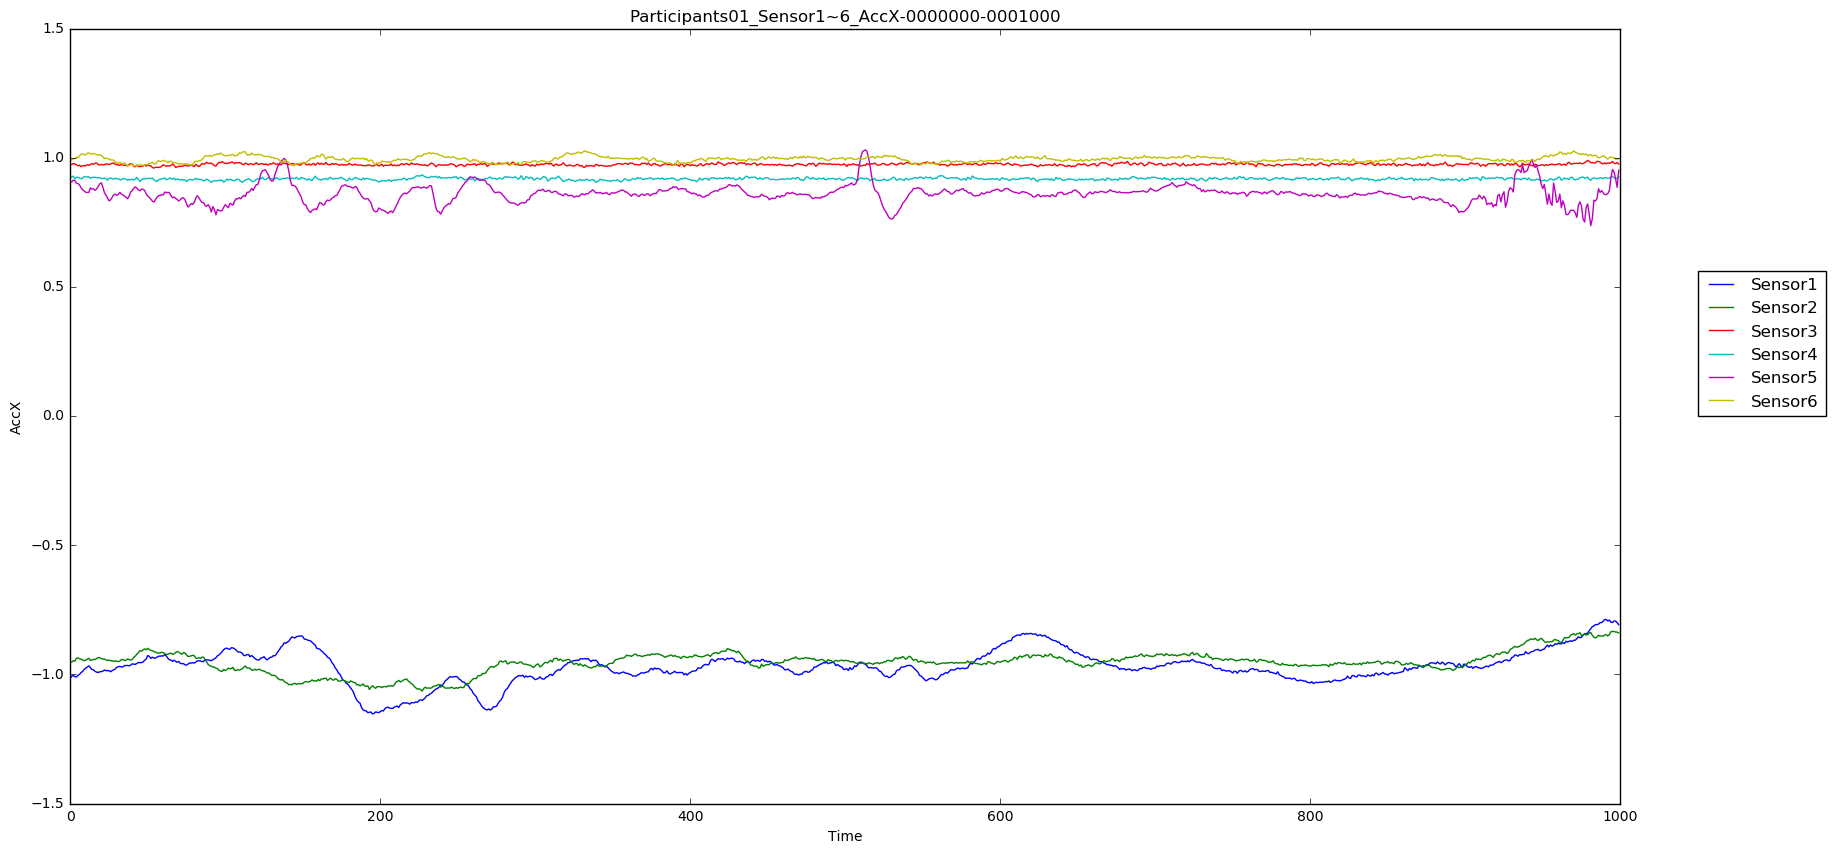

KeyboardInterrupt: 

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')


for PltRng in tqdm_notebook(range(0,1077000,1000),leave=False):
    ax.plot(range(PltRng,PltRng+1000), Sensor1['AccX'][PltRng:PltRng+1000],label='Sensor1')
    ax.plot(range(PltRng,PltRng+1000), Sensor2['AccX'][PltRng:PltRng+1000],label='Sensor2')
    ax.plot(range(PltRng,PltRng+1000), Sensor3['AccX'][PltRng:PltRng+1000],label='Sensor3')
    ax.plot(range(PltRng,PltRng+1000), Sensor4['AccX'][PltRng:PltRng+1000],label='Sensor4')
    ax.plot(range(PltRng,PltRng+1000), Sensor5['AccX'][PltRng:PltRng+1000],label='Sensor5')
    ax.plot(range(PltRng,PltRng+1000), Sensor6['AccX'][PltRng:PltRng+1000],label='Sensor6')

    lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

    ax.set_title("Participants01_Sensor1~6_AccX-"+str( PltRng ).zfill(7)+'-'+str( PltRng+1000 ).zfill(7))


    filename = "Participants01_Sensor1~6_AccX"+str( PltRng ).zfill(7)+'-'+str( PltRng+1000 ).zfill(7)+".png"
    ax.figure.savefig(GraphPath+filename,bbox_extra_artists=(lgnd,), bbox_inches='tight')

    plt.show()
    
    ax.clear()
    time.sleep(0.1)

ウィンドウフレームごとのグラフ

In [ ]:
Sensor1['AccX'].shape

In [21]:
print xrange(4)

<function min>

  8%|▊         | 2540/33682 [00:00<00:01, 25386.28it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =33682
offset=808382.0


 61%|██████▏   | 20685/33682 [00:07<00:11, 1116.83it/s]


KeyboardInterrupt: 

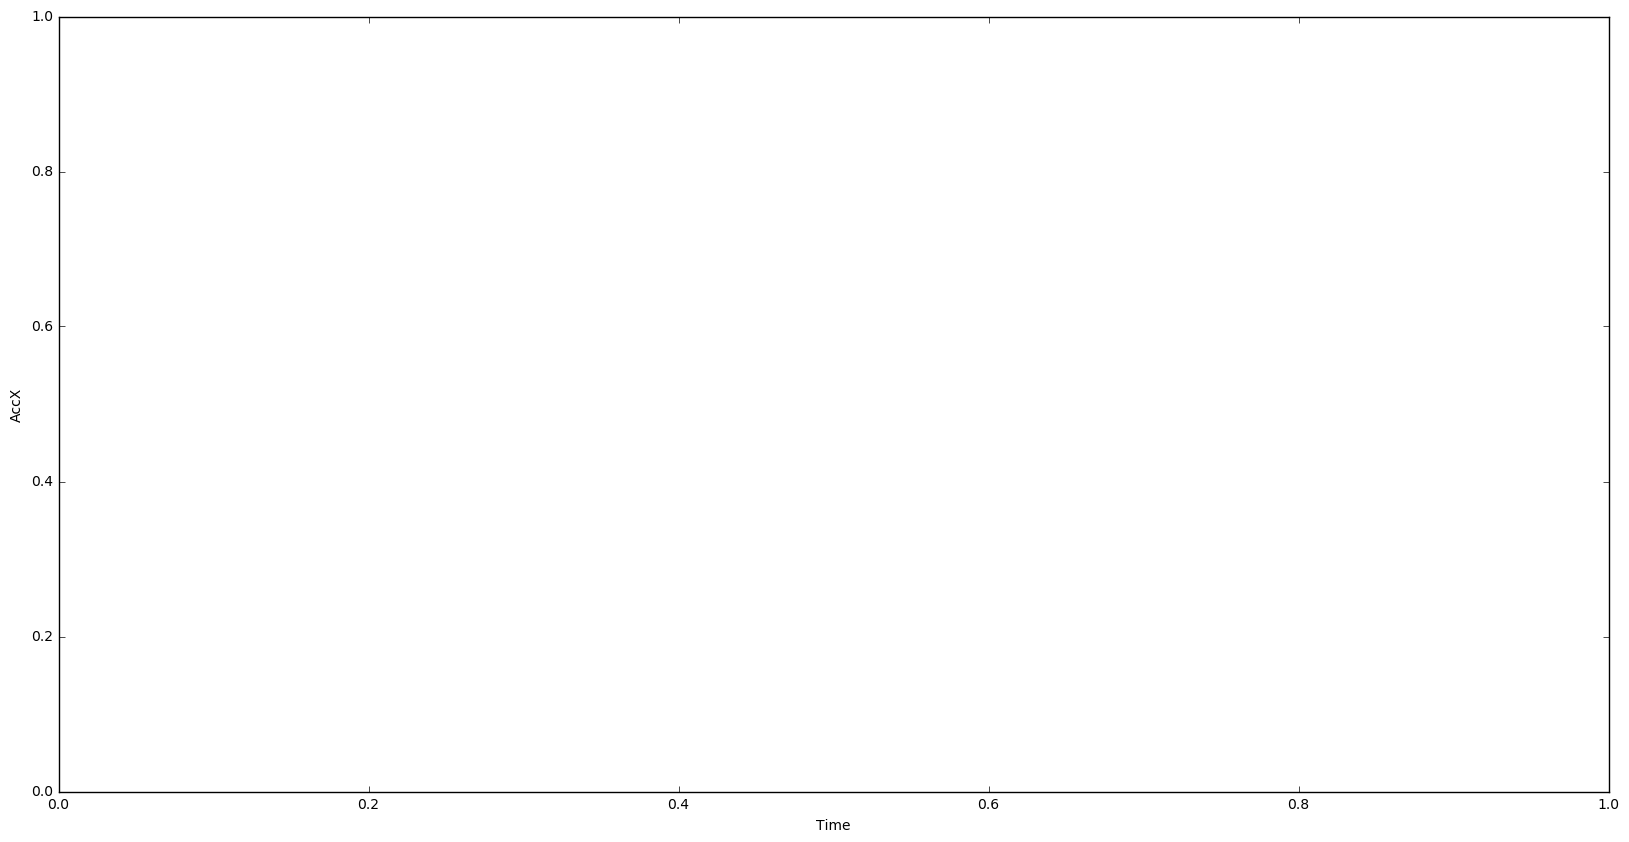

In [24]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')

w=window()
w.SetData('AccX',Sensor1['AccX'])
wind=w.Compile(windowWidth=32,slidingWidth=16)

RngPlotGraph = 10

for PltRng in tqdm_notebook( range(0,33683,32*RngPlotGraph),leave=False ):
    for i in tqdm_notebook( range(0,RngPlotGraph),leave=False ):
        MIN = wind[PltRng+i,:32].min()
        MAX = wind[PltRng+i,:32].max()
        ax.plot(range(i*32,(i+1)*32), wind[PltRng+i,:32],label='Sensor1'+'WindNum'+str(i))
        ax.plot([i*32, i*32], [MIN,MAX ], 'k-', lw=2)
    
    lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

    ax.set_title("Participants01_Sensor1_AccX_Each_WindFrame-"+str(PltRng).zfill(7)+'-'+str(PltRng+32*20).zfill(7))


    filename = "Participants01_Sensor1_AccX"+str(PltRng).zfill(5)+'-'+str(PltRng+32*50).zfill(5)+".png"
    ax.figure.savefig(GraphPath+filename,bbox_extra_artists=(lgnd,), bbox_inches='tight')

    plt.show()
    
    ax.clear()
    time.sleep(1)

In [16]:
wind[1,:]

array([-0.7065, -0.7121, -0.7158, -0.7119, -0.7092, -0.7109, -0.7129,
       -0.7089, -0.7048, -0.7151, -0.7097, -0.7033, -0.7109, -0.7104,
       -0.7077, -0.7085, -0.7068, -0.7053, -0.7036, -0.6989, -0.6958,
       -0.7024, -0.7046, -0.7014, -0.7011, -0.6955, -0.7031, -0.7004,
       -0.7026, -0.698 , -0.6989, -0.707 ])